# Part 1
#### Assignment
Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. 
- Show how different parameters passed to the Classifier affect the overfitting issue. 
- Perform cross-validation to mitigate the overfitting of your model. 

Once you assessed your model,
- inspect the `feature_importances_` attribute and discuss the obtained results. 
- With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

## Plan
1. First we will just lok at the Random Forest classifier without any parameters (just use the default) -> gives very good scores.

2. Look a bit at the feature_importances

3. Then we see that it is better to aggregate the data by player (We can't show overfitting with 'flawed' data and very good scores, so we first aggregate)

3. Load the data aggregated by player

4. Look again at the classifier with default parameters

5. Show the effect of some parameters to overfitting and use that to...

6. ...find acceptable parameters

7. Inspect the feature_importances and discuss the results

8. At the end we look very briefly at other classifiers.

Note that we use the values 1, 2, 3, 4, 5 or WW, W, N, B, BB interchangably for the _skin color categories_ of the players


In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import itertools
# sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing as pp
from sklearn.model_selection import KFold , cross_val_score, train_test_split, validation_curve
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve
import sklearn.preprocessing as preprocessing

%matplotlib inline
sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500) # to see all columns

Load the preprocessed data and look at it. We preprocess the data in the _HW01-1-Preprocessing_ notebook.
The data is already encoded to be used for the RandomForestClassifier.

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st_preprocessed_encoded.csv', index_col=0)
data_total = data.copy()
print('Number of dayads', data.shape)
data.head()

Number of dayads (124468, 27)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,color_rating
0,901,1046,70,3,1382,177.0,72.0,0,1,0,0,1,0,0,0,0,1532,1,1,59,0.326391,712.0,0.000564,0.396000,750.0,0.002696,2
1,739,919,51,1,320,179.0,82.0,12,1,0,0,1,0,1,0,0,497,2,2,153,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,4
5,0,392,34,0,360,182.0,71.0,1,1,0,0,1,0,0,0,0,1081,4,4,87,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1
6,45,425,48,0,446,187.0,80.0,7,1,1,0,0,0,0,0,0,1175,4,4,87,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1
7,64,440,54,0,158,180.0,68.0,4,1,0,0,1,0,0,0,0,803,4,4,87,0.325185,127.0,0.003297,0.538462,130.0,0.013752,5


In [3]:
print('Number of diads: ', len(data))
print('Number of players: ', len(data.playerShort.unique()))
print('Number of referees: ', len(data.refNum.unique()))

Number of diads:  124468
Number of players:  1585
Number of referees:  2967


First we just train and test the preprocessed data with the default values of the Random Forest to see what happens.
For this first model, we will use all the features (color_rating) and then we will observe which are the most important.


In [4]:
player_colors = data['color_rating']
rf_input_data = data.drop(['color_rating'], axis=1)
player_colors.head() # values 1 to 5

0    2
1    4
5    1
6    1
7    5
Name: color_rating, dtype: int64

In [5]:
rf = RandomForestClassifier()
cross_val_score(rf, rf_input_data, player_colors, cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=1)

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   10.1s finished


array([ 0.9009559 ,  0.90769602,  0.90721401,  0.90496465,  0.89918059,
        0.90752792,  0.90855765,  0.90984331,  0.90196866,  0.8114102 ])

Quite good results...

### Observe the important features

In [6]:
def show_important_features_random_forest(X, y, rf=None):
    if rf is None:
        rf = RandomForestClassifier()

    # train the forest
    rf.fit(X, y)

    # find the feature importances
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    # plot the feature importances
    cols = X.columns
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%d. feature n° %d %s (%f)" % (f + 1, indices[f], cols[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()  


Feature ranking:
1. feature n° 16 photoID (0.122345)
2. feature n° 4 birthday (0.115253)
3. feature n° 1 player (0.111621)
4. feature n° 0 playerShort (0.103963)
5. feature n° 2 club (0.098145)
6. feature n° 5 height (0.093648)
7. feature n° 6 weight (0.091261)
8. feature n° 7 position (0.072684)
9. feature n° 17 refNum (0.042760)
10. feature n° 3 leagueCountry (0.029596)
11. feature n° 8 games (0.014045)
12. feature n° 9 victories (0.013239)
13. feature n° 11 defeats (0.011574)
14. feature n° 10 ties (0.009905)
15. feature n° 23 meanExp (0.007912)
16. feature n° 13 yellowCards (0.007684)
17. feature n° 18 refCountry (0.007649)
18. feature n° 12 goals (0.007440)
19. feature n° 22 seIAT (0.006939)
20. feature n° 20 meanIAT (0.006780)
21. feature n° 19 Alpha_3 (0.006467)
22. feature n° 24 nExp (0.006446)
23. feature n° 25 seExp (0.005851)
24. feature n° 21 nIAT (0.005588)
25. feature n° 15 redCards (0.000602)
26. feature n° 14 yellowReds (0.000601)


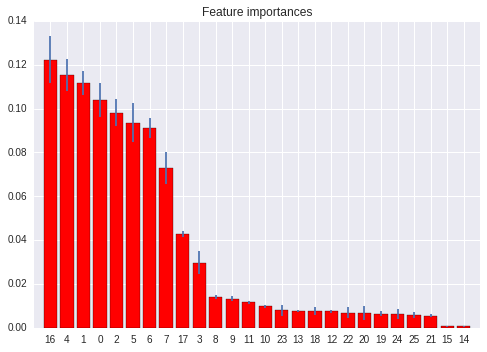

In [7]:
show_important_features_random_forest(rf_input_data, player_colors)

We can see that the most important features are:
    - photoID
    - player
    - the birthday
    - playerShort
    
The obtained result is weird. From personal experience, those 4 features should to be independant of the skin color and they also should be unique to one player. PhotoID is the id of the photo and thus unique for one player and independent of the skin_color. Same about 'player' and 'playerShort' (both represent the players name). Birthday is not necessarily unique, but should not be that important for the skin color since people all over the world are born all the time.

We have to remember that our data contains dyads between player and referee, so a player can appear several times in our data. It could be the reason why the unique features for the players are imprtant. Let's look at the data:

In [8]:
data.playerShort.value_counts()[:10]

415     202
732     197
681     196
541     195
1552    188
587     183
1226    181
1578    181
1388    180
603     177
Name: playerShort, dtype: int64

Indeed, some players appear around 200 times, so it is easy to determine the skin-color of the player _djibril cisse_ if he appears both in the training set and in the test set. But in the reality the probability to have 2 _djibril cisse_ with the same birthday and same color skin is almost null.
The reason why this attributes are so important is that some of the rows of one player appear in the train and test set, so the classifier can take those to determine the skin-color.

So we drop those attributes and see what happens.

In [9]:
rf_input_data_drop = rf_input_data.drop(['birthday', 'player','playerShort', 'photoID'], axis=1)

In [10]:
rf = RandomForestClassifier()
result = cross_val_score(rf, rf_input_data_drop, player_colors, cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=1)

result

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    8.1s finished


array([ 0.73242831,  0.8341099 ,  0.82712082,  0.85274743,  0.83242288,
        0.85763638,  0.85407794,  0.86934512,  0.85279229,  0.71876256])

The accuracy of the classifier dropped a bit, which is no surprise.

Feature ranking:
1. feature n° 0 club (0.178953)
2. feature n° 3 weight (0.176450)
3. feature n° 2 height (0.168424)
4. feature n° 4 position (0.125820)
5. feature n° 13 refNum (0.079695)
6. feature n° 1 leagueCountry (0.040261)
7. feature n° 5 games (0.030236)
8. feature n° 6 victories (0.029016)
9. feature n° 8 defeats (0.023984)
10. feature n° 7 ties (0.021706)
11. feature n° 10 yellowCards (0.018247)
12. feature n° 9 goals (0.017444)
13. feature n° 19 meanExp (0.012899)
14. feature n° 15 Alpha_3 (0.011582)
15. feature n° 14 refCountry (0.011461)
16. feature n° 17 nIAT (0.010785)
17. feature n° 18 seIAT (0.010582)
18. feature n° 16 meanIAT (0.010461)
19. feature n° 20 nExp (0.009467)
20. feature n° 21 seExp (0.009010)
21. feature n° 12 redCards (0.001786)
22. feature n° 11 yellowReds (0.001731)


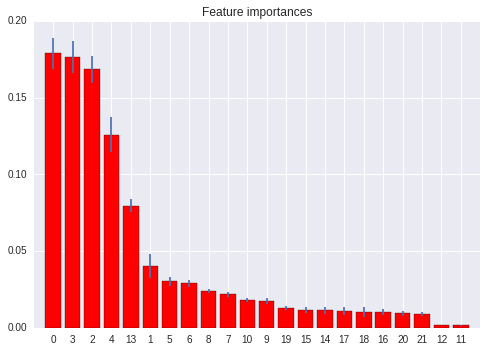

In [11]:
show_important_features_random_forest(rf_input_data_drop, player_colors)

That makes more sences, it is possible that dark persons are statistically taller than white persons, but the club and position should not be that important. 
So we decided to aggregate on the players name to have only one row with the personal information of one player

We do the aggregation in the _HW04-1-Preprocessing_ notebook.

## Aggregated data

Load the aggregated data.

In [12]:
data_aggregated = pd.read_csv('CrowdstormingDataJuly1st_aggregated_encoded.csv')
data_aggregated.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCount,refCountryCount,meanIAT,seIAT,meanExp,seExp,color_rating,meanIAT_nIAT,meanExp_nExp,meanIAT_GameNbr,meanExp_GameNbr,meanIAT_cards,meanExp_cards
0,0,392,34,0,360,182.0,71.0,1,654,247,179,228,9,19,0,0,166,37,0.346459,0.001505,0.494575,0.009691,1,0.328409,0.367721,0.333195,0.400637,0.0,0.0
1,1,393,91,2,176,183.0,73.0,0,336,141,73,122,62,42,0,1,99,25,0.348818,0.000834,0.449220,0.003823,2,0.329945,0.441615,0.341438,0.380811,0.0,0.0
2,2,394,83,0,719,165.0,63.0,11,412,200,97,115,31,11,0,0,101,28,0.345893,0.001113,0.491482,0.006350,2,0.328230,0.365628,0.332389,0.399459,0.0,0.0
3,3,395,6,0,1199,178.0,76.0,3,260,150,42,68,39,31,0,1,104,37,0.346821,0.003786,0.514693,0.015240,1,0.327775,0.412859,0.336638,0.433294,0.0,0.0
4,4,396,51,1,758,180.0,73.0,1,124,41,40,43,1,8,4,2,37,11,0.331600,0.000474,0.335587,0.001745,2,0.338847,0.379497,0.331882,0.328895,0.0,0.0


Drop the player unique features because they can't be usefull to classify since they are unique.

In [13]:
data_aggregated = data_aggregated.drop(['playerShort', 'player', 'birthday'], axis=1)

Train the defualt classifier on the new data and look at the important features

In [14]:
rf = RandomForestClassifier()
aggr_rf_input_data = data_aggregated.drop(['color_rating'], axis=1)
aggr_player_colors = data_aggregated['color_rating']

result = cross_val_score(rf, aggr_rf_input_data, aggr_player_colors, 
                         cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=1)
print("mean result: ", np.mean(result))
result

mean result:  0.408735311136


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished


array([ 0.46583851,  0.41614907,  0.40993789,  0.34375   ,  0.4591195 ,
        0.36708861,  0.42675159,  0.3974359 ,  0.42307692,  0.37820513])

The results are not very impressive...

Feature ranking:
1. feature n° 17 meanExp (0.053188)
2. feature n° 22 meanExp_GameNbr (0.052176)
3. feature n° 19 meanIAT_nIAT (0.050324)
4. feature n° 13 refCount (0.050280)
5. feature n° 21 meanIAT_GameNbr (0.047262)
6. feature n° 20 meanExp_nExp (0.047205)
7. feature n° 8 defeats (0.047056)
8. feature n° 2 height (0.046914)
9. feature n° 16 seIAT (0.045756)
10. feature n° 6 victories (0.045160)
11. feature n° 7 ties (0.045087)
12. feature n° 15 meanIAT (0.045038)
13. feature n° 0 club (0.044296)
14. feature n° 9 goals (0.044147)
15. feature n° 10 yellowCards (0.043996)
16. feature n° 18 seExp (0.043789)
17. feature n° 5 games (0.042500)
18. feature n° 4 position (0.042376)
19. feature n° 3 weight (0.039308)
20. feature n° 14 refCountryCount (0.037292)
21. feature n° 11 yellowReds (0.021654)
22. feature n° 23 meanIAT_cards (0.017406)
23. feature n° 12 redCards (0.017297)
24. feature n° 1 leagueCountry (0.016107)
25. feature n° 24 meanExp_cards (0.014388)


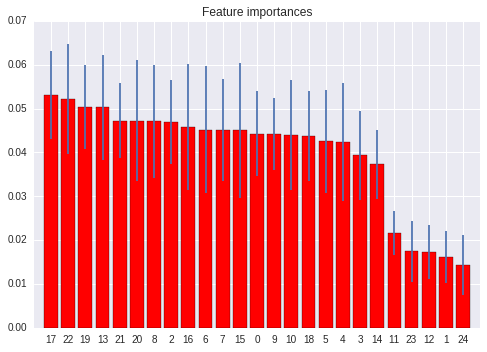

In [15]:
show_important_features_random_forest(aggr_rf_input_data, aggr_player_colors)

That makes a lot more sense. The features are much more equal and several *IAT and *EXP are on top.

But before going more into detail, we adress the overfitting issue mentioned in the assignment. 

## Show overfitting issue
The classifier overfitts when the Training accuracy is much higher than the testing accuracy (the classifier fits too much to the trainig data and thus generalizes badly).
So we look at the different parameters and discuss how they contribute to the overfitting issue. 

To show the impact of each parameter we try different values and plot the train vs test accuracy.
Luckily there is a function for this :D

In [16]:
# does the validation with cross validation
def val_curve_rf(input_data, y, param_name, param_range, cv=5, rf=RandomForestClassifier()):
    return validation_curve(rf, input_data, y, param_name, param_range, n_jobs=10,verbose=0, cv=cv)
    
# defines the parameters and the ranges to try
def val_curve_all_params(input_data, y, rf=RandomForestClassifier()):
    params = {
             'class_weight': ['balanced', 'balanced_subsample', None],
             'criterion': ['gini', 'entropy'],
             'n_estimators': [1, 10, 100, 500, 1000, 2000],
             'max_depth': list(range(1, 100, 5)),
             'min_samples_split': [0.001,0.002,0.004,0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.8, 0.9],
             'min_samples_leaf': list(range(1, 200, 5)),
             'max_leaf_nodes': [2, 50, 100, 200, 300, 400, 500, 1000]
        }
    RandomForestClassifier
    # does the validation for all parameters from above
    for p, r in params.items():
        train_scores, valid_scores = val_curve_rf(input_data, y, p, r, rf=rf)
        plot_te_tr_curve(train_scores, valid_scores, p, r)
        
def plot_te_tr_curve(train_scores, valid_scores, param_name, param_range, ylim=None):
    """
    Generate the plot of the test and training(validation) accuracy curve.
    """
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid()

    # if the parameter values are strings
    if isinstance(param_range[0], str):
        plt.subplot(1, 2, 1)
        plt.title(param_name+" train")
        plt.boxplot(train_scores.T, labels=param_range)
        plt.subplot(1, 2, 2)
        plt.title(param_name+" test")
        plt.boxplot(valid_scores.T, labels=param_range)
        
        
    # parameter names are not strings (are numeric)
    else:
        plt.title(param_name)
        plt.ylabel("accuracy")
        plt.xlabel("value")
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(valid_scores, axis=1)
        test_scores_std = np.std(valid_scores, axis=1)
        
        plt.fill_between(param_range, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(param_range, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(param_range, train_scores_mean, '-', color="r",
                 label="Training score")
        plt.plot(param_range, test_scores_mean, '-', color="g",
             label="Testing score")

    plt.legend(loc="best")
    return plt

/home/lukas/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


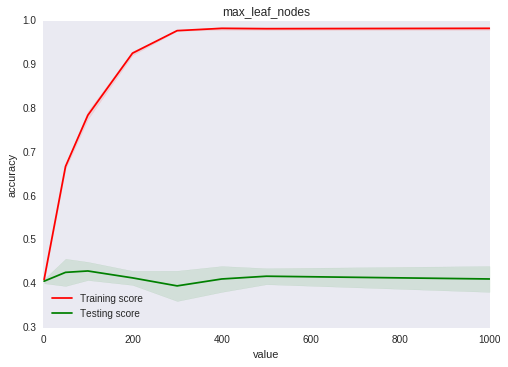

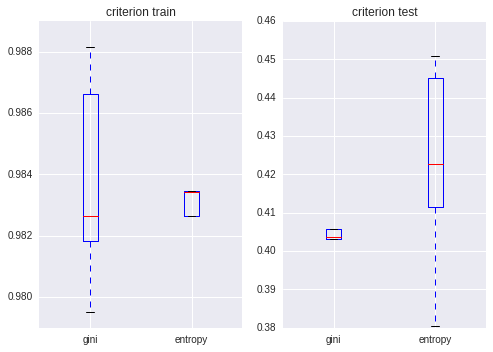

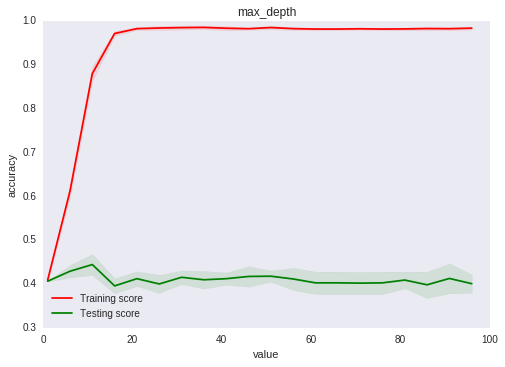

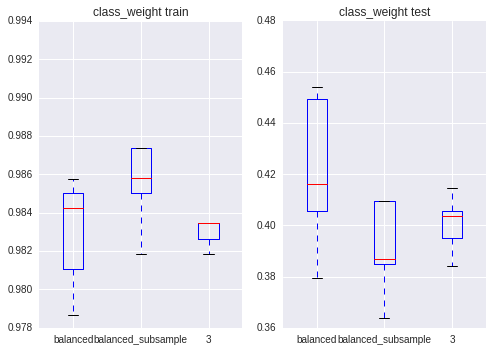

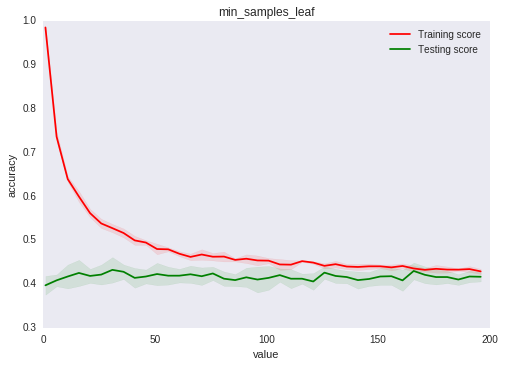

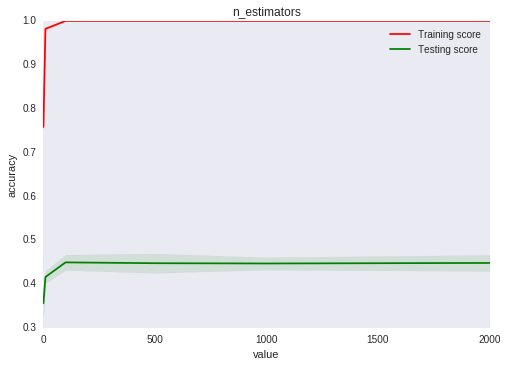

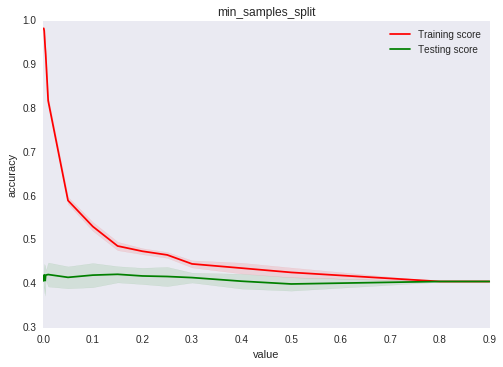

In [17]:
val_curve_all_params(aggr_rf_input_data, aggr_player_colors, rf)

**n_estimators**
How many trees to be used. As expected, we see that more trees improve the train and test accuracy, however the test accuracy is bounded and it does not really make sense to use more than 500 trees. (Adding trees also means more computation time).
More trees also mean more overfitting. The train accuracy goes almost to 1 while the test stays around 0.42.

**min_samples_leaf**
The minimum number of samples required to be at a leaf node. The higher this value, the less overfitting. It effectively limits how good a tree can fit to a given train set.

**criterion**
The function to measure the quality of a split. You can see that 'entropy' scores higher in the test. So we take it even though gini has a much lover variance.

**max_depth**
The maximal depth of the tree. The higher the more the tree overfits. It seems that no tree is grown more than 10 deep. So we wont limit it.

**max_leaf_nodes**
An upper limit on how many leaf the tree can have. The train accuracy grows until about 400 where there is no more gain in more leaf nodes. probably because the trees don't create that big leaf nodes anyway.

**min_samples_split**
The minimum number of samples required to split an internal node. Has a similar effect and behaviour as _min_samples_leaf_.

**class_weight**
Weights associated with classes. Gives more weight to classes with fewer members. It does not seem to have a big influence.
Note that the third option is _None_ which sets all classes weight to 1.

### Find a good classifier
The default classifier achieves about 40% accuracy. This is not much considering that about 40% of players are in category 2. This classifier is not better than classifying all players into category 2.
So we are going to find better parameters for the classifier.

Based on the plots above and trial and error, we find good parameters for the RandomForestClassifier and look if feature importance changed.

In [18]:
rf_good = RandomForestClassifier(n_estimators=500, 
                                    max_depth=None, 
                                    criterion='entropy',
                                    min_samples_leaf=2,
                                    min_samples_split=5,
                                    class_weight='balanced_subsample')

aggr_rf_input_data = data_aggregated.drop(['color_rating'], axis=1)
aggr_player_colors = data_aggregated['color_rating']

result = cross_val_score(rf_good, aggr_rf_input_data, aggr_player_colors, 
                         cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=1)
print("mean result: ", np.mean(result))
result

mean result:  0.445497351009


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   25.0s finished


array([ 0.42236025,  0.49068323,  0.42236025,  0.40625   ,  0.4591195 ,
        0.43670886,  0.47133758,  0.41025641,  0.46794872,  0.46794872])

Feature ranking:
1. feature n° 16 seIAT (0.055072)
2. feature n° 15 meanIAT (0.055031)
3. feature n° 0 club (0.054059)
4. feature n° 18 seExp (0.052388)
5. feature n° 17 meanExp (0.051513)
6. feature n° 21 meanIAT_GameNbr (0.051173)
7. feature n° 13 refCount (0.050510)
8. feature n° 22 meanExp_GameNbr (0.050238)
9. feature n° 19 meanIAT_nIAT (0.048816)
10. feature n° 20 meanExp_nExp (0.048091)
11. feature n° 10 yellowCards (0.045149)
12. feature n° 6 victories (0.042279)
13. feature n° 2 height (0.042217)
14. feature n° 8 defeats (0.041908)
15. feature n° 9 goals (0.041495)
16. feature n° 5 games (0.040951)
17. feature n° 7 ties (0.039476)
18. feature n° 3 weight (0.039409)
19. feature n° 4 position (0.036260)
20. feature n° 14 refCountryCount (0.036127)
21. feature n° 1 leagueCountry (0.025112)
22. feature n° 12 redCards (0.016655)
23. feature n° 11 yellowReds (0.015732)
24. feature n° 24 meanExp_cards (0.010884)
25. feature n° 23 meanIAT_cards (0.009457)


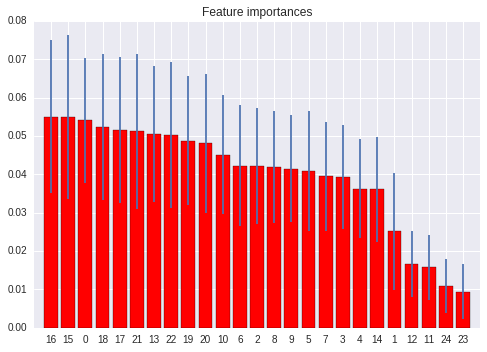

In [19]:
show_important_features_random_forest(aggr_rf_input_data, aggr_player_colors, rf=rf_good)

We can see that the accuracy is only a bit better. But the most important features are even more balanced. The confidence intervalls are huge and almost all features could be on top. More importantly, the *IAT and *EXP features seem to play some role in gaining those 4% of accuracy. But clearly we can't say that there is a big difference between players of different skin colors.

## Observe the confusion matrix

Now we observe the confusion matrix to see what the classifier accutally does. We split the data in training ans testing set (test set = 25%) and then we train our random forest using the best parameters selected above:

In [32]:
x_train, x_test, y_train, y_test = train_test_split(aggr_rf_input_data, aggr_player_colors, test_size=0.25)
rf_good.fit(x_train, y_train)
prediction = rf_good.predict(x_test)
accuracy = accuracy_score(y_test, prediction)
print('Accuracy: ',accuracy)

Accuracy:  0.448362720403


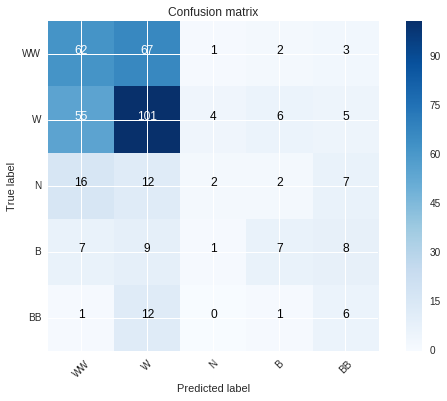

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_test, prediction)
class_names = ['WW', 'W', 'N', 'B', 'BB']
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

Our model predicts almost only 2 categories instead of 5. It predicts mostly WW or W. This is because we have imbalanced data and the balancing did not really help apparently. We can see in the matrix above by looking at the True label that there is clearly a majority of of white player. Let's have a look at the exact distribution.

(array([ 1189.,   145.,   251.]),
 array([ 1.        ,  2.33333333,  3.66666667,  5.        ]),
 <a list of 3 Patch objects>)

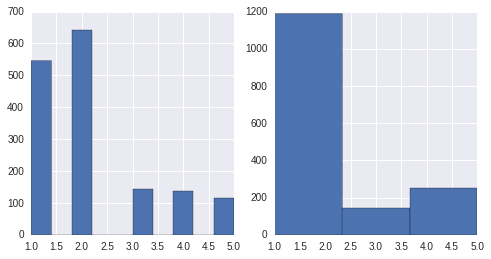

In [22]:
fig, ax  = plt.subplots(1, 2, figsize=(8, 4))

ax[0].hist(aggr_player_colors)
ax[1].hist(aggr_player_colors, bins=3)

Those 2 histograms show the imbalance data. Indeed the 2 first category represent more than 50% of the data. Let's look at the numbers

In [23]:
print('Proportion of WW: {:.2f}%'.format(
        100*aggr_player_colors[aggr_player_colors == 1].count()/aggr_player_colors.count()))
print('Proportion of W: {:.2f}%'.format(
        100*aggr_player_colors[aggr_player_colors == 2].count()/aggr_player_colors.count()))
print('Proportion of N: {:.2f}%'.format(
        100*aggr_player_colors[aggr_player_colors == 3].count()/aggr_player_colors.count()))
print('Proportion of B: {:.2f}%'.format(
        100*aggr_player_colors[aggr_player_colors == 4].count()/aggr_player_colors.count()))
print('Proportion of BB: {:.2f}%'.format(
        100*aggr_player_colors[aggr_player_colors == 5].count()/aggr_player_colors.count()))

Proportion of WW: 34.45%
Proportion of W: 40.57%
Proportion of N: 9.15%
Proportion of B: 8.64%
Proportion of BB: 7.19%


WW and W reprensent 75% of the data.

Now assume a new classifier that always classify in the W category. This classifier has an accuracy of 40%. It means that our classifiery is not much better than always classifying a player as W...
What happens when we do a ternary and binary classification?

### Binary Classification

For ternary we put _WW_ and _W_ in one class, _N_ in the second and _B_ _BB_ in the last (the classes then are _WWW_, _N_ and _BBB_.

For binary we merge the N with the BBB class. -> _WWW_ vs _NBBB_

In [24]:
player_colors_3 = aggr_player_colors.map(lambda x: 1 if(x == 1 or x == 2) else max(x, 2) )
player_colors_2 = player_colors_3.map(lambda x: min(x, 2) )

In [25]:
result3 = cross_val_score(rf_good, aggr_rf_input_data, player_colors_3, 
                         cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=1)

result2 = cross_val_score(rf_good, aggr_rf_input_data, player_colors_2, 
                         cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=1)

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   18.7s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   16.2s finished


In [26]:
print('Proportion of WWW: {:.2f}%'.format(
        100*player_colors_2[player_colors_2 == 1].count()/player_colors_2.count()))
print('Proportion of NBBB: {:.2f}%'.format(
        100*player_colors_2[player_colors_2 == 2].count()/player_colors_2.count()))


Proportion of WWW: 75.02%
Proportion of NBBB: 24.98%


In [27]:
print("mean res3: ", np.mean(result3))
print("mean res2: ", np.mean(result2))

mean res3:  0.764751519761
mean res2:  0.779235800631


We see that our classifier is only a little bit better than the 'stupid' one. The difference between the ternary and binary classification is also small. 

Confusion Matrix of the binary classifier:

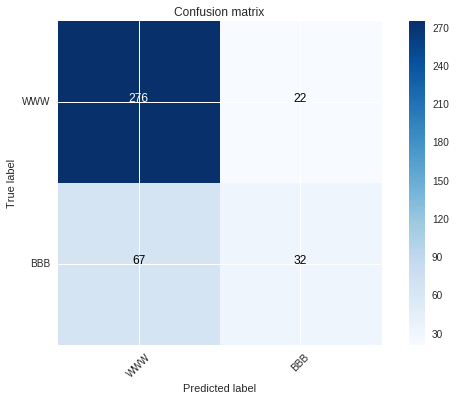

In [28]:
x_train, x_test, y_train, y_test = train_test_split(aggr_rf_input_data, player_colors_2, test_size=0.25)
rf_good.fit(x_train, y_train)
prediction = rf_good.predict(x_test)
accuracy = accuracy_score(y_test, prediction)
cm = confusion_matrix(y_test, prediction)
class_names = ['WWW', 'BBB']
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

Even for the 2 class problem it is hard to predict the colors and the classifier still mostly predicts WWW. 
From that results we might conclude that there is just not enough difference between the 'black' and 'white' players to classify them.



### Try other classifiers
A quick and short exploration of other classifiers to show that the RandomForest is not the 'wrong' classifier for that problem.

TLDR; They don't do better than the RandomForest.

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier


In [30]:
def make_print_confusion_matrix(clf, clf_name):
    x_train, x_test, y_train, y_test = train_test_split(aggr_rf_input_data, player_colors_2, test_size=0.25)
    clf.fit(x_train, y_train)
    prediction = clf.predict(x_test)
    accuracy = np.mean(cross_val_score(clf, aggr_rf_input_data, player_colors_2, cv=5, n_jobs=3, pre_dispatch='n_jobs+1', verbose=1))
    print(clf_name + ' Accuracy: ',accuracy)
    cm = confusion_matrix(y_test, prediction)
    class_names = ['WWW', 'BBB']
    plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix of '+clf_name)
    plt.show()

Only the AdaBoostClassifier is slightly better than our random forest. Probably because it uses our rf_good random forest and combines the results smartly. That might explain the extra 1%

For the MLP classifier we just tried a few architectures, there might be better ones... 

Note that the accuracy score is the result of 5 way cross validation.

[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.4s finished


SVC Accuracy:  0.748900859076


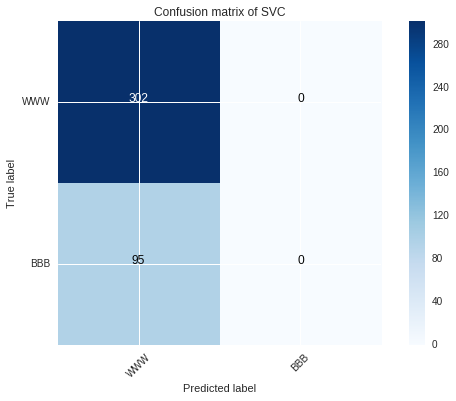

[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   15.6s finished


AdaBoostClassifier Accuracy:  0.7804567088


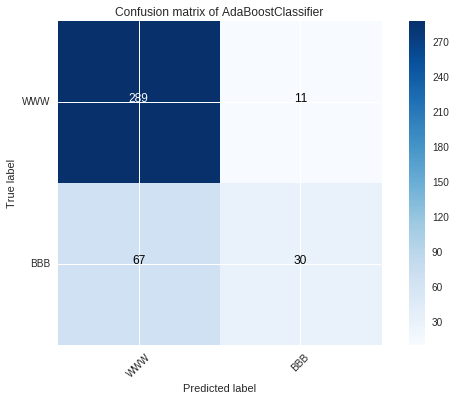

[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   13.4s finished


MLPclassifier Accuracy:  0.688352649795


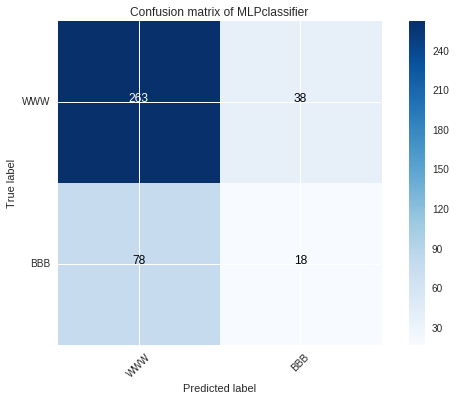

[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.0s finished


GaussianNB Accuracy:  0.65297556128


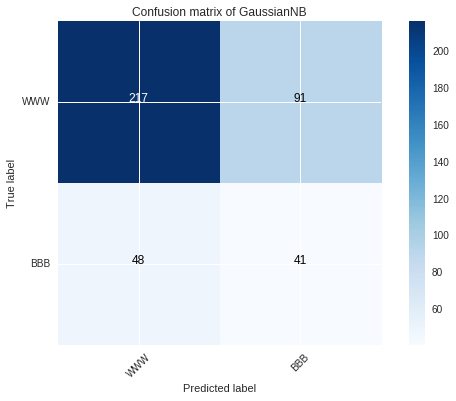

In [31]:
make_print_confusion_matrix(svm.SVC(kernel='rbf', degree=3, class_weight='balanced'), "SVC")
make_print_confusion_matrix(AdaBoostClassifier(n_estimators=500, base_estimator=rf_good), "AdaBoostClassifier")

make_print_confusion_matrix(MLPClassifier(activation='tanh', learning_rate='adaptive', 
                                          solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100, 50, 50, 2), random_state=1), 
                            "MLPclassifier")

make_print_confusion_matrix(GaussianNB(), "GaussianNB")
